In [1]:
%matplotlib notebook

from IPython.display import Image
from simplify.face_lattice import *
from simplify.simplify import *
from simplify.plot import *
from simplify.homothety import *
from islpy import *
from IPython.display import Image
import networkx as nx
import graphviz as gv
from islplot.support import *
import islplot.plotter as islp

constraints:
c0	[[-1  1 10]	{ [i, j] : 10 - i + j >= 0 }
c1	 [ 0  1  0]	{ [i, j] : j >= 0 }
c2	 [ 0 -1 15]	{ [i, j] : 15 - j >= 0 }
c3	 [ 1 -1  0]]	{ [i, j] : i - j >= 0 }

Simplifications
@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-10 + i)] }
  L@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, 0] } 
    @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
  R@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-15 + i)] }
    L@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-4 + j)] }
      L@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [-1, 0] } 
        @{}:@{2}, {[i,j]->[i]} :: Action.NONE 
      R@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, 0] } 
        @{}:@{2}, {[i,j]->[i]} :: Action.NONE 
    R@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [-1, 0] } 
      @{}:@{1}, {[i,j]->[i]} :: Action.NONE 


<IPython.core.display.Javascript object>


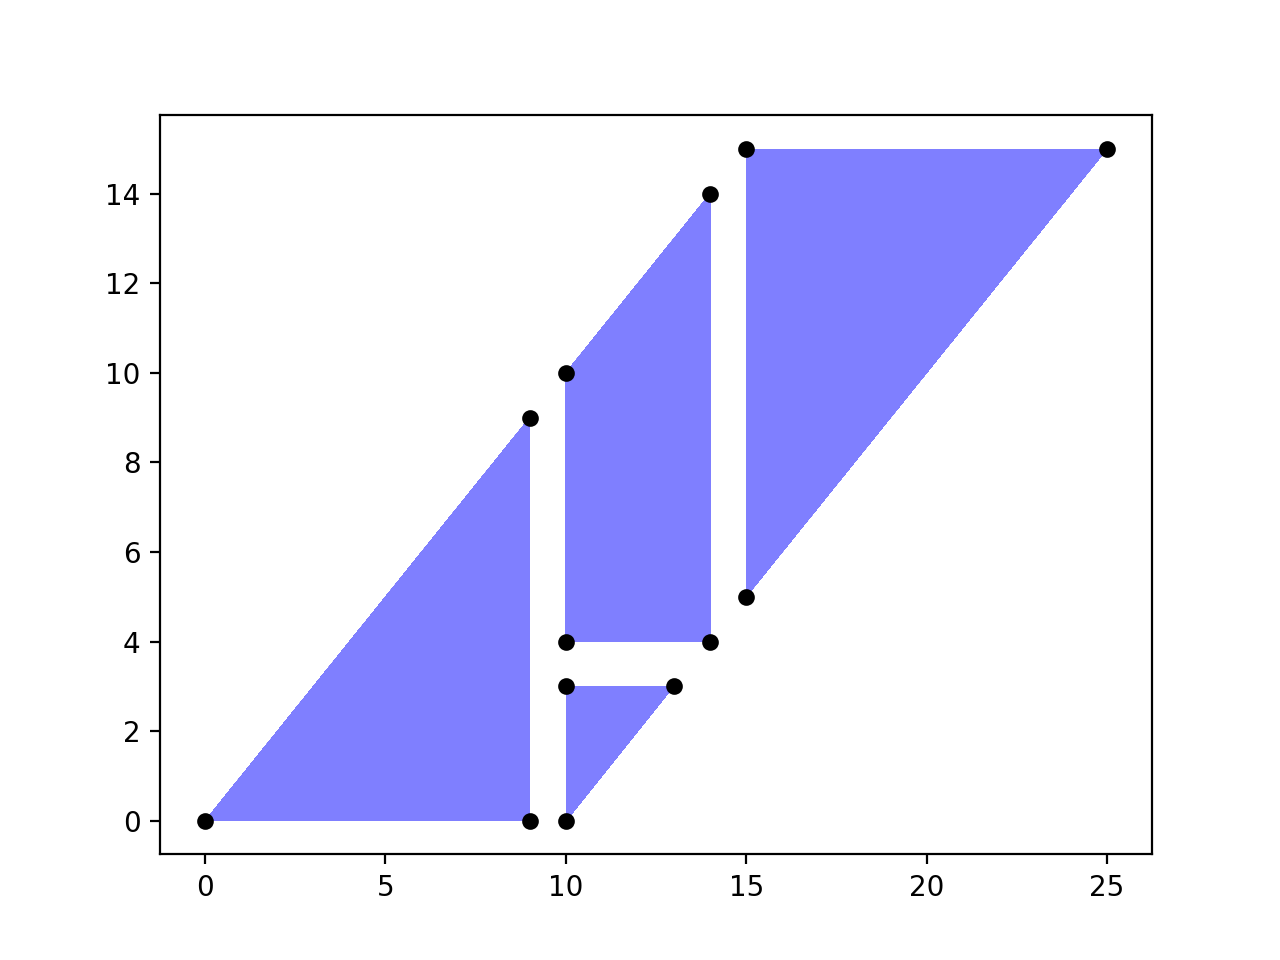

In [2]:
# simplest 2D parallelogram
op = 'max'
fp = '{[i,j]->[i]}'
fd = '{[i,j]->[j]}'
s = '{[i,j] : 0<=j and i-10<=j and j<=i and j<=15 }'

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set()):
        islp.plot_bset_shape(P, figure=fig)

constraints:
c0	[[ 0  1  0  0]	[N] -> { [i, j] : j >= 0 }
c1	 [-1  1  1  0]	[N] -> { [i, j] : N - i + j >= 0 }
c2	 [ 1 -1  0  0]	[N] -> { [i, j] : i - j >= 0 }
c3	 [ 0 -2  3  0]]	[N] -> { [i, j] : 3N - 2j >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(-3N + 2i)] }
  L@{}:@{}, [N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(-N + i)] }
    L@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [1, 0] } 
      @{}:@{1}, [N]->{[i,j]->[i]} :: Action.NONE 
    R@{}:@{}, [N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j] -> [(1 - N + 2j)] }
      L@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [-1, 0] } 
        @{}:@{2}, [N]->{[i,j]->[i]} :: Action.NONE 
      R@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [1, 0] } 
        @{}:@{3}, [N]->{[i,j]->[i]} :: Action.NONE 
  R@{}:@{}, [N]->{[i,j]->[i]} :: Action.RHO, [N = 0] -> { [-1, 0] } 
    @{}:@{2}, [N]->{[i,j]->[i]} :: Action.NONE 


<IPython.core.display.Javascript object>


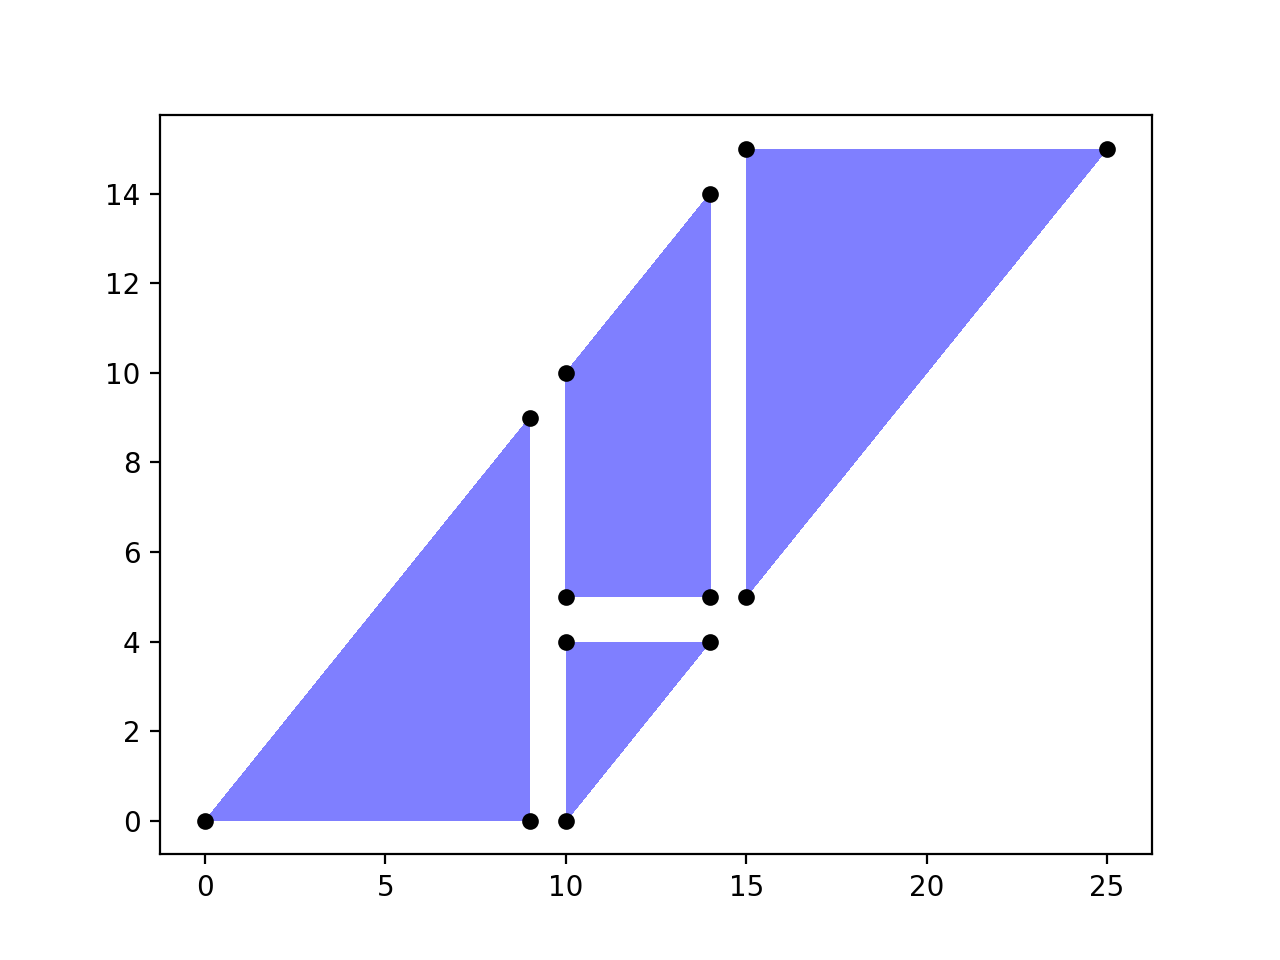

In [3]:
# simplest parametric 2D parallelogram
op = 'max'
fp = '[N]->{[i,j]->[i]}'
fd = '[N]->{[i,j]->[j]}'
s = '[N]->{[i,j] : 0<=j and i-N<=j and j<=i and j<=3N/2 }'
dom = BasicSet('[N]->{[i,j] : N=10 }')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set()):
        islp.plot_bset_shape(P.intersect(dom), figure=fig)

constraints:
c0	[[ 0  0  1 -1 -1]	[M, N] -> { [i, j] : -1 + M - N >= 0 }
c1	 [ 0  1  0  0  0]	[M, N] -> { [i, j] : j >= 0 }
c2	 [-1  1  0  1  0]	[M, N] -> { [i, j] : N - i + j >= 0 }
c3	 [ 1 -1  0  0  0]	[M, N] -> { [i, j] : i - j >= 0 }
c4	 [ 0 -1  1  0  0]]	[M, N] -> { [i, j] : M - j >= 0 }

Simplifications
@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-N + i)] }
  L@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [1, 0] } 
    @{}:@{3}, [M,N]->{[i,j]->[i]} :: Action.NONE 
  R@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-N + j)] }
    L@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [-1, 0] } 
      @{}:@{2}, [M,N]->{[i,j]->[i]} :: Action.NONE 
    R@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.INDEX_SET_SPLIT at [M, N] -> { [i, j] -> [(-2N + i)] }
      L@{}:@{}, [M,N]->{[i,j]->[i]} :: Action.RHO, [M = 0, N = 0] -> { [1, 0] } 
        @{}:@{4}, [M,N]->{[i,j]->[i]} :: Action.NONE 
      R

<IPython.core.display.Javascript object>


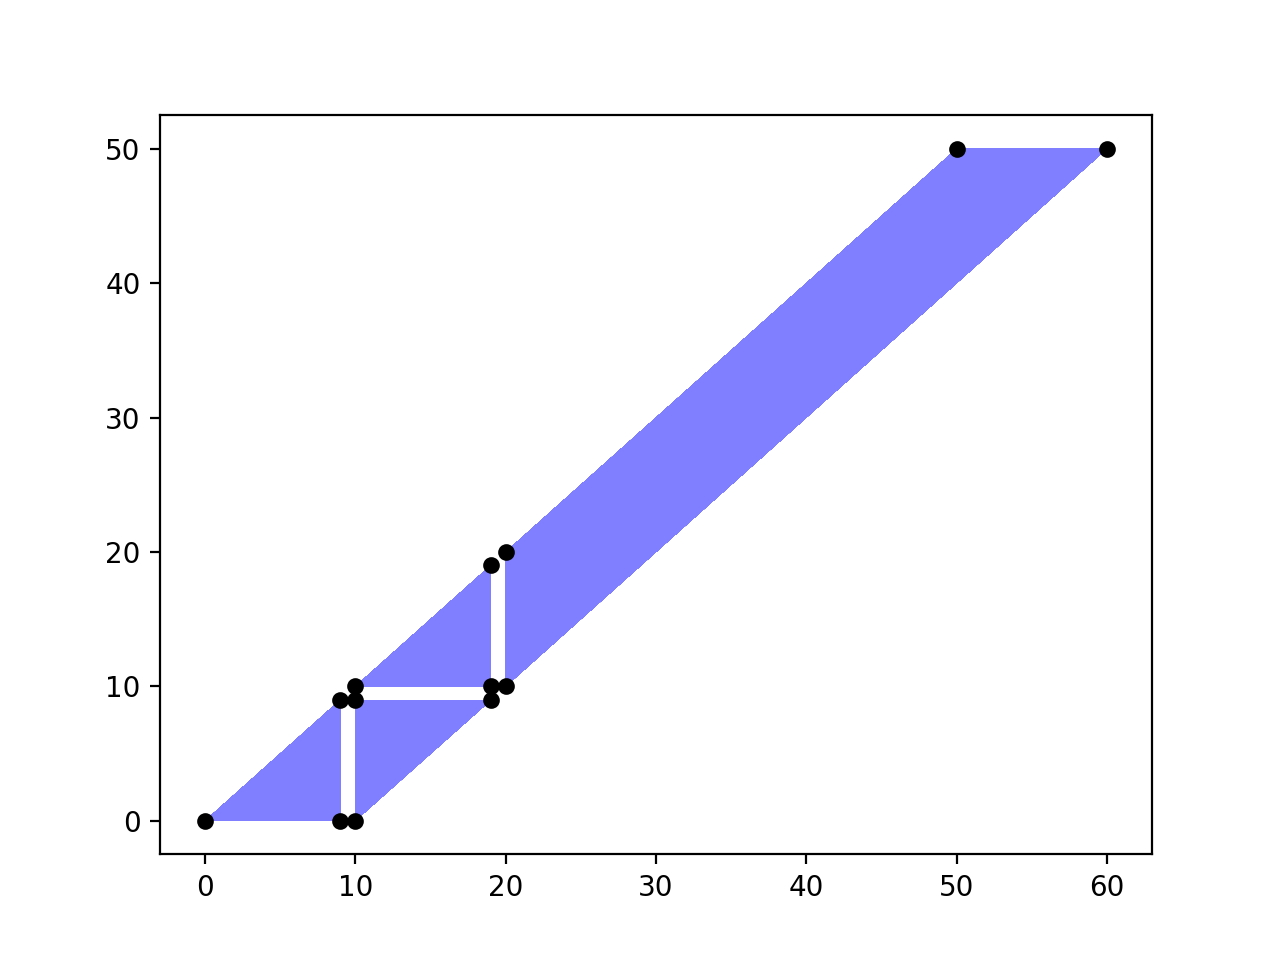

In [12]:
# simplest parametric 2D parallelogram
op = 'max'
fp = '[M,N]->{[i,j]->[i]}'
fd = '[M,N]->{[i,j]->[j]}'
s = '[M,N]->{[i,j] : 0<=j and i-N<=j and j<=i and j<=M and N<M }'
dom = BasicSet('[M,N]->{[i,j] : N=10 and M=50 }')

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set()):
        islp.plot_bset_shape(P.intersect(dom), figure=fig)

<IPython.core.display.Javascript object>


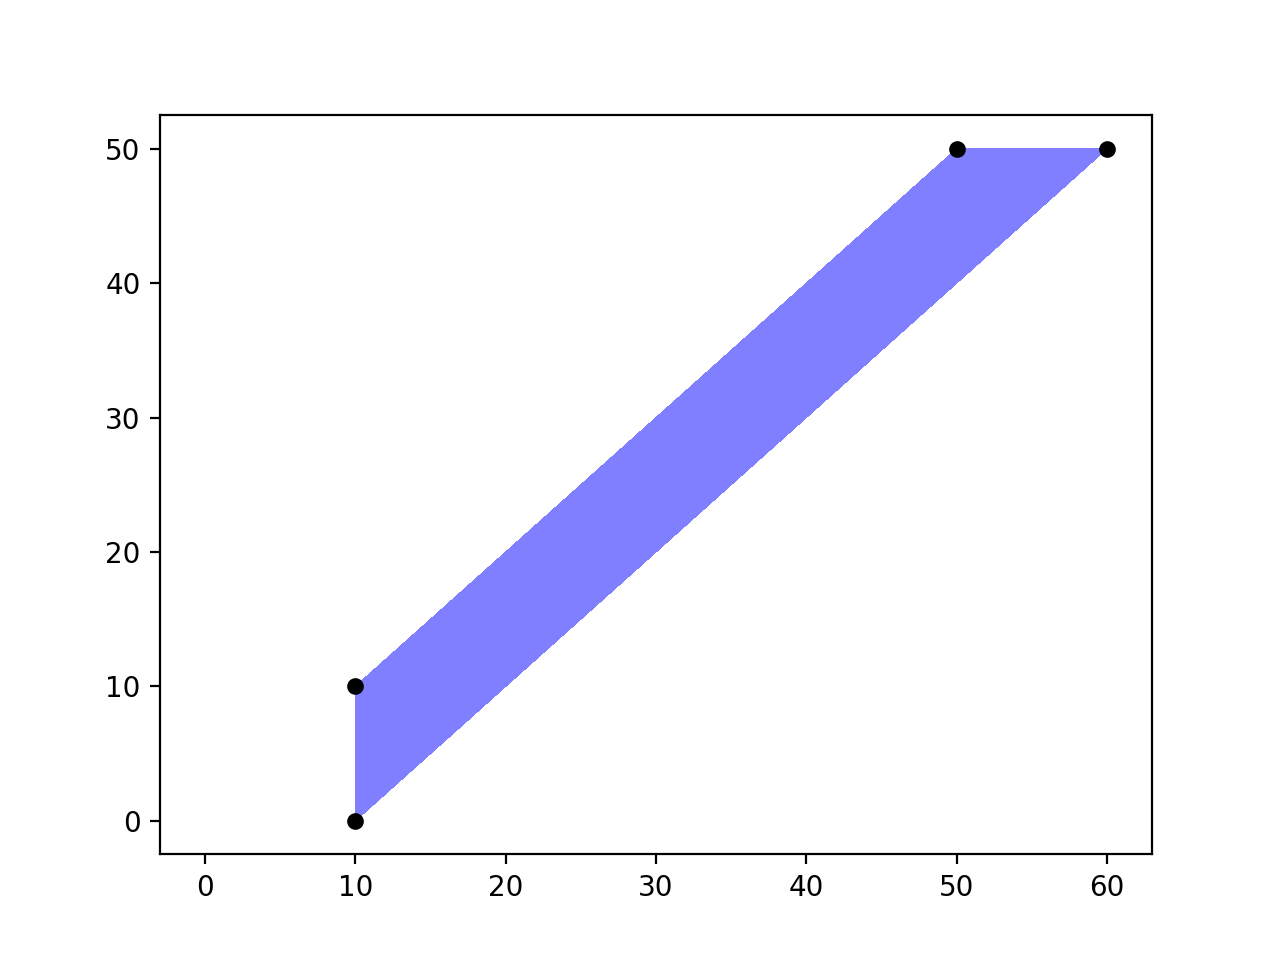

In [15]:
islp.plot_bset_shape(BasicSet('[M, N] -> { [i, j] : N < M and i >= N and -N + i <= j <= i and j <= M }').intersect(dom), figure=islp._plt.figure())


In [5]:
# simplest parametric 2D parallelogram
op = 'max'
fp = '[M,N]->{[i,j]->[i]}'
fd = '[M,N]->{[i,j]->[j]}'
s = '[M,N]->{[i,j] : 0<=j and i-N<=j and j<=i and j<=M and N<M }'
dom = BasicSet('[M,N]->{[i,j] : N=10 and M=5 }')

#successes = start(op, fp, s, fd, verbose=False, report_all=False)

#fig = islp._plt.figure()
#for success in successes:
#    S = None
#    for P in success.get_splits(result=set()):
#        islp.plot_bset_shape(P.intersect(dom), figure=fig)

constraints:
c0	[[-1  1 10]	{ [i, j] : 10 - i + j >= 0 }
c1	 [ 0  1  0]	{ [i, j] : j >= 0 }
c2	 [ 0 -1 15]	{ [i, j] : 15 - j >= 0 }
c3	 [ 1 -1  0]]	{ [i, j] : i - j >= 0 }

Simplifications
@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-10 + i + j)] }
  L@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [-1, 1] } 
    @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
  R@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-10 + i)] }
    L@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, -1] } 
      @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
    R@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-20 + i + j)] }
      L@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, -1] } 
        @{}:@{0}, {[i,j]->[i]} :: Action.NONE 
      R@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-15 + i)] }
        L@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, -1] } 
          @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
        R@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> 

<IPython.core.display.Javascript object>


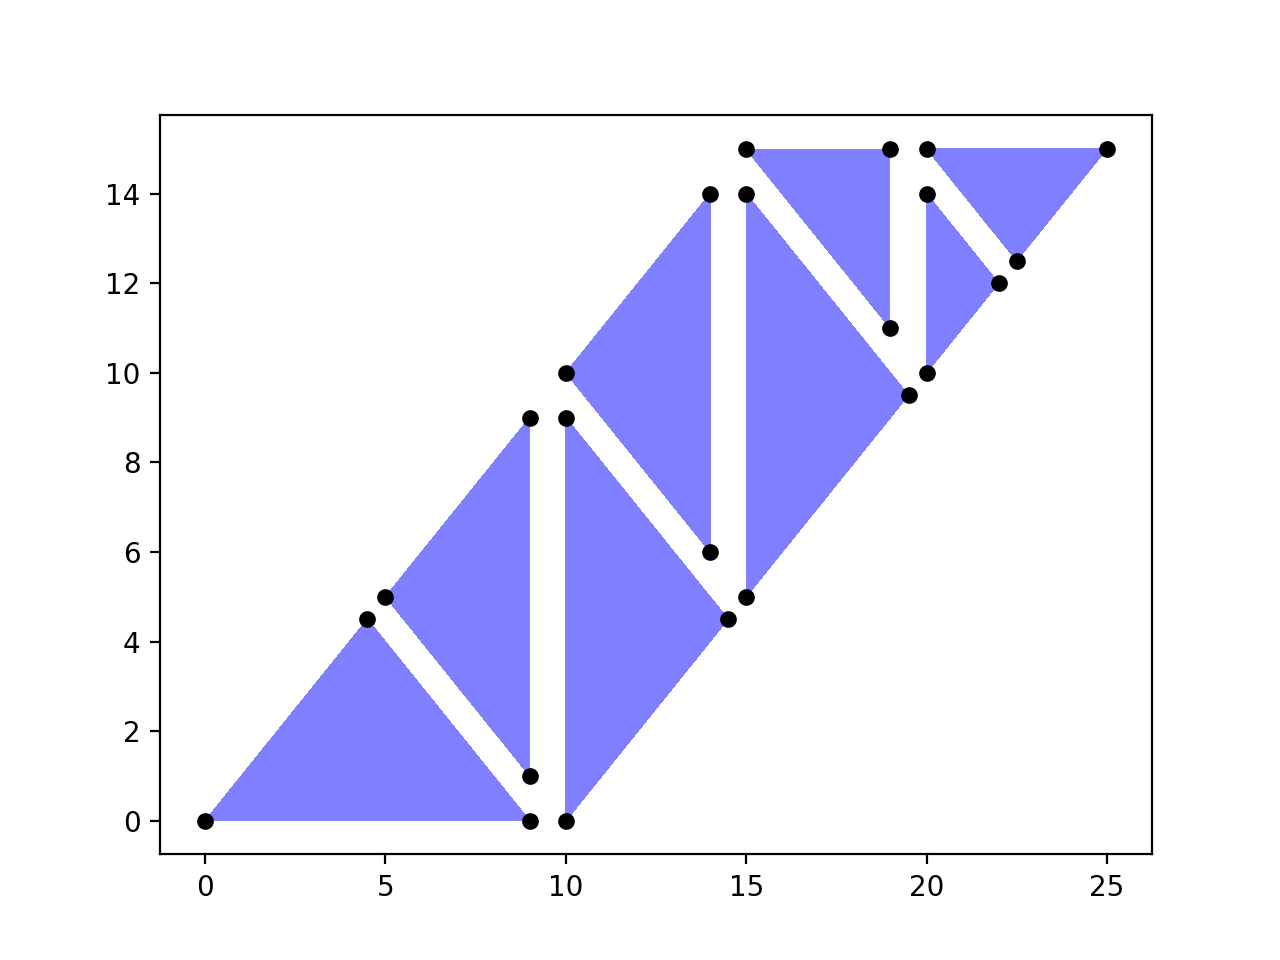

In [6]:
# simplest 2D parallelogram
op = 'max'
fp = '{[i,j]->[i]}'
fd = '{[i,j]->[i+j]}'
s = '{[i,j] : 0<=j and i-10<=j and j<=i and j<=15 }'

successes = start(op, fp, s, fd, verbose=False, report_all=False, check_homothety=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set()):
        islp.plot_bset_shape(P, figure=fig)

constraints:
c0	[[-1  1 10]	{ [i, j] : 10 - i + j >= 0 }
c1	 [ 0  1  0]	{ [i, j] : j >= 0 }
c2	 [ 1 -1  0]	{ [i, j] : i - j >= 0 }
c3	 [ 1 -2 14]]	{ [i, j] : 14 + i - 2j >= 0 }

Simplifications
@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-14 + j)] }
  L@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-10 + i)] }
    L@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, 0] } 
      @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
    R@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-13 + i)] }
      L@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> [(-2 + j)] }
        L@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [-1, 0] } 
          @{}:@{2}, {[i,j]->[i]} :: Action.NONE 
        R@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [1, 0] } 
          @{}:@{2}, {[i,j]->[i]} :: Action.NONE 
      R@{}:@{}, {[i,j]->[i]} :: Action.RHO, { [-1, 0] } 
        @{}:@{1}, {[i,j]->[i]} :: Action.NONE 
  R@{}:@{}, {[i,j]->[i]} :: Action.INDEX_SET_SPLIT at { [i, j] -> 

<IPython.core.display.Javascript object>


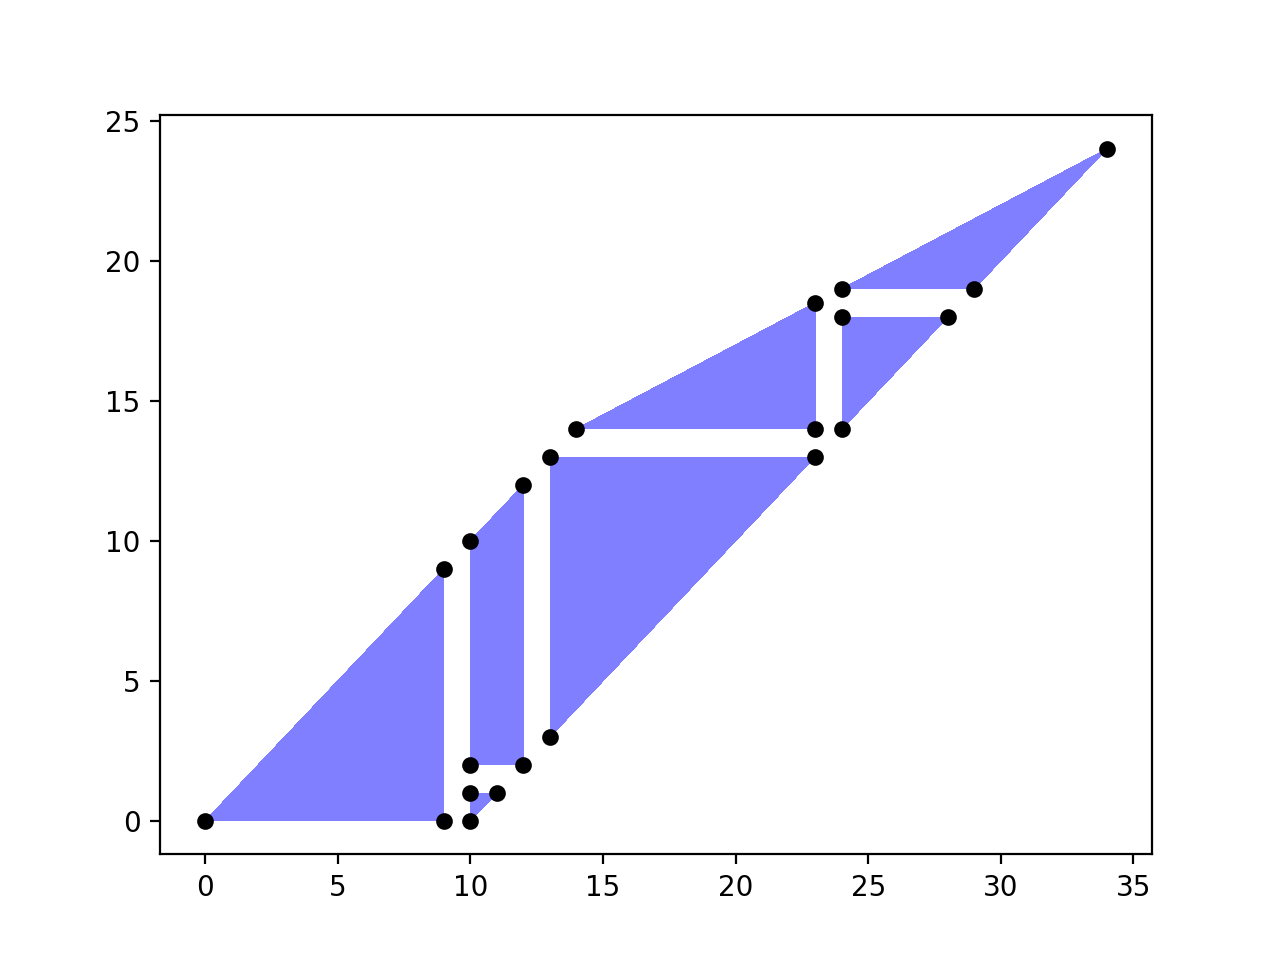

In [7]:
# slightly less simple 2D example
op = 'max'
fp = '{[i,j]->[i]}'
fd = '{[i,j]->[j]}'
s = '{[i,j] : 0<=j and i-10<=j and j<=i and 2j<=i+14 }'

successes = start(op, fp, s, fd, verbose=False, report_all=False)

fig = islp._plt.figure()
for success in successes:
    S = None
    for P in success.get_splits(result=set()):
        islp.plot_bset_shape(P, figure=fig)

constraints:
c0	[[ 0  0  1  0  0]	[N] -> { [i, j, k] : k >= 0 }
c1	 [-1  0  1  1  0]	[N] -> { [i, j, k] : N - i + k >= 0 }
c2	 [ 0 -1  1  1  0]	[N] -> { [i, j, k] : N - j + k >= 0 }
c3	 [ 0  1 -1  0  0]	[N] -> { [i, j, k] : j - k >= 0 }
c4	 [ 1  0 -1  0  0]	[N] -> { [i, j, k] : i - k >= 0 }
c5	 [ 0  0 -1  2  0]]	[N] -> { [i, j, k] : 2N - k >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(-2N + j)] }
  L@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(1 - N + i)] }
    L@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.RHO, [N = 0] -> { [1, 0, 0] } 
      @{}:@{3}, [N]->{[i,j,k]->[i,j]} :: Action.RHO, [N = 0] -> { [0, -1, 0] } 
        @{}:@{3, 4}, [N]->{[i,j,k]->[i,j]} :: Action.NONE 
    R@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(1 - N + j)] }
      L@{}:@{}, [N]->{[i,j,k]->[i,j]} :: Action.RHO, [N = 0] -> { [-1, 1, 0] } 
        @{}:@{4}, [N]->{[i,j,k]->[i,j]

<IPython.core.display.Javascript object>


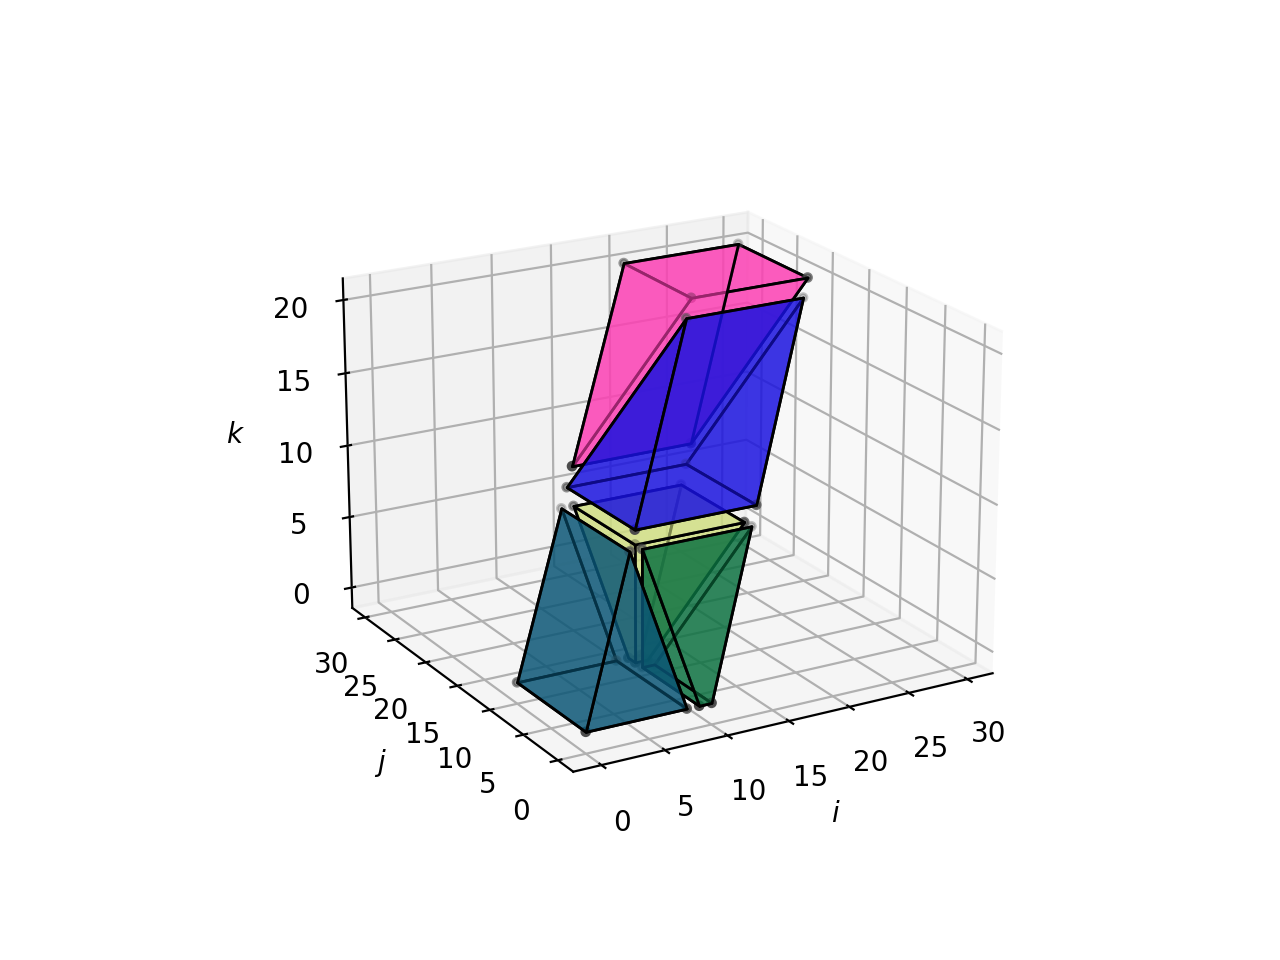

In [8]:
# 3D parallelpiped - v0
op = 'max'
fp = '[N]->{[i,j,k]->[i,j]}'
fd = '[N]->{[i,j,k]->[k]}'
s = '[N]->{[i,j,k] : k<=i,j<=N+k and 0<=k<=2N}'

# visualization
dom = BasicSet('[N]->{[i,j,k] : N=10}')

successes = start(op, fp, s, fd, verbose=False, report_all=False, check_homothety=False)

for success in successes:
    P = [p.intersect(dom) for p in success.get_splits(result=set())]
    plot_3d_sets(P)

constraints:
c0	[[ 0  0  1  0  0]	[N] -> { [i, j, k] : k >= 0 }
c1	 [-1  0  1  1  0]	[N] -> { [i, j, k] : N - i + k >= 0 }
c2	 [ 0 -1  1  1  0]	[N] -> { [i, j, k] : N - j + k >= 0 }
c3	 [ 0  1 -1  0  0]	[N] -> { [i, j, k] : j - k >= 0 }
c4	 [ 1  0 -1  0  0]	[N] -> { [i, j, k] : i - k >= 0 }
c5	 [ 0  0 -2  3  0]]	[N] -> { [i, j, k] : 3N - 2k >= 0 }

Simplifications
@{}:@{}, [N]->{[i,j,k]->[2i-j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(-2i + j)] }
  L@{}:@{}, [N]->{[i,j,k]->[2i-j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(5N - 4i + 2j)] }
    L@{}:@{}, [N]->{[i,j,k]->[2i-j]} :: Action.RHO, [N = 0] -> { [-1, 1, 0] } 
      @{}:@{3}, [N]->{[i,j,k]->[2i-j]} :: Action.RHO, [N = 0] -> { [0, 1, 0] } 
        @{}:@{2, 3}, [N]->{[i,j,k]->[2i-j]} :: Action.NONE 
    R@{}:@{}, [N]->{[i,j,k]->[2i-j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(-1 - N + k)] }
      L@{}:@{}, [N]->{[i,j,k]->[2i-j]} :: Action.INDEX_SET_SPLIT at [N] -> { [i, j, k] -> [(2N - 2i + j)] }

<IPython.core.display.Javascript object>


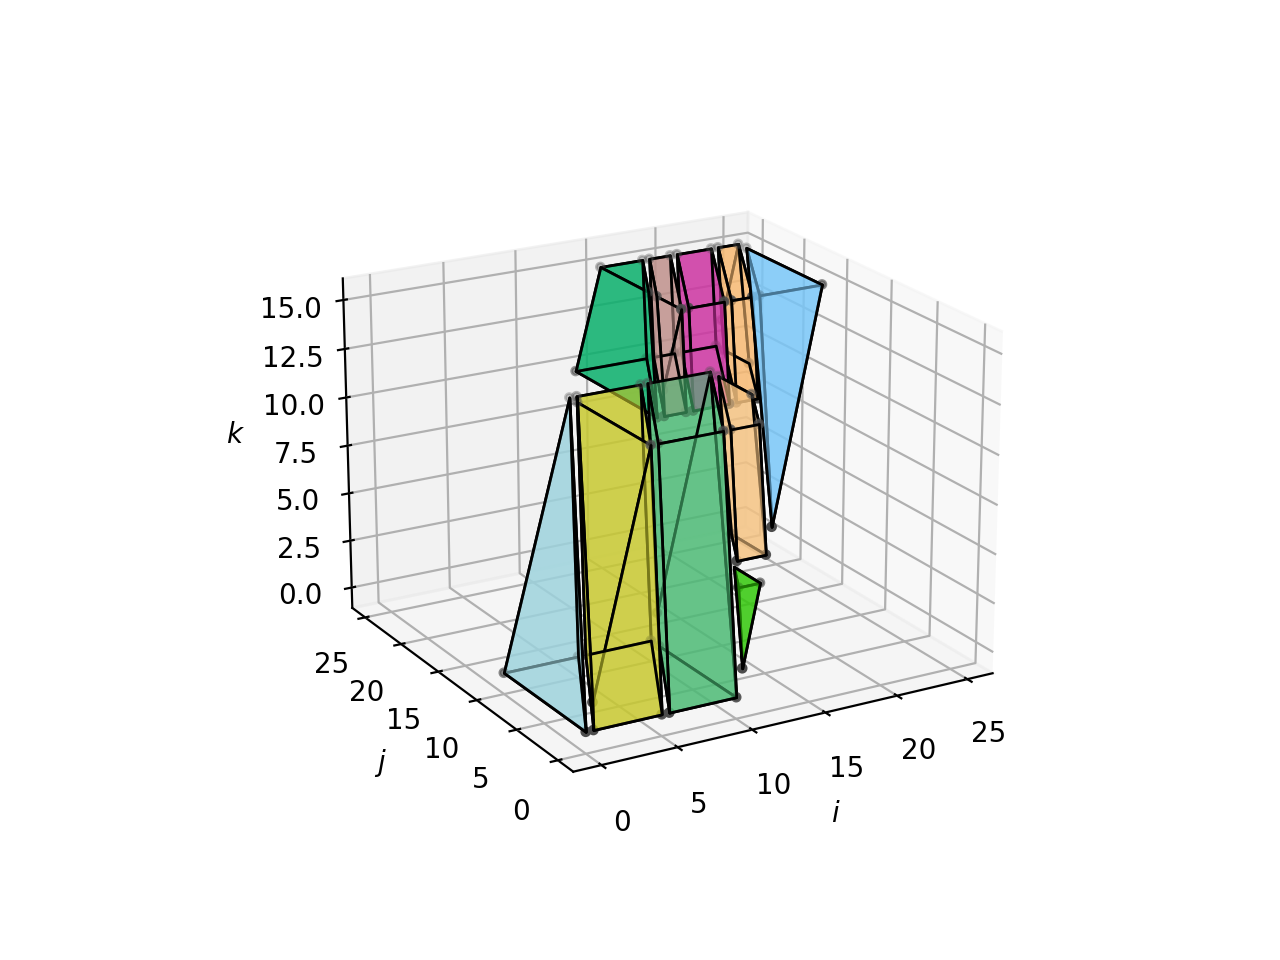

In [9]:
# 3D parallelpiped - v1
op = 'max'
fp = '[N]->{[i,j,k]->[2i-j]}'
fd = '[N]->{[i,j,k]->[k]}'
s = '[N]->{[i,j,k] : k<=i,j<=N+k and 0<=k<=3N/2}'

# visualization
dom = BasicSet('[N]->{[i,j,k] : N=10}')

successes = start(op, fp, s, fd, verbose=False, report_all=False, check_homothety=False)

for success in successes:
    P = [p.intersect(dom) for p in success.get_splits(result=set())]
    plot_3d_sets(P)

constraints:
c0	[[ 0  0  0 -1  1 -1]	[N, M] -> { [i, j, k] : -1 - N + M >= 0 }
c1	 [ 0  0  1  0  0  0]	[N, M] -> { [i, j, k] : k >= 0 }
c2	 [-1  0  1  1  0  0]	[N, M] -> { [i, j, k] : N - i + k >= 0 }
c3	 [ 0 -1  1  1  0  0]	[N, M] -> { [i, j, k] : N - j + k >= 0 }
c4	 [ 0  1 -1  0  0  0]	[N, M] -> { [i, j, k] : j - k >= 0 }
c5	 [ 1  0 -1  0  0  0]	[N, M] -> { [i, j, k] : i - k >= 0 }
c6	 [ 0  0 -1  0  1  0]]	[N, M] -> { [i, j, k] : M - k >= 0 }

Simplifications
@{}:@{}, [N,M]->{[i,j,k]->[j]} :: Action.INDEX_SET_SPLIT at [N, M] -> { [i, j, k] -> [(-M + j)] }
  L@{}:@{}, [N,M]->{[i,j,k]->[j]} :: Action.INDEX_SET_SPLIT at [N, M] -> { [i, j, k] -> [(-N + j)] }
    L@{}:@{}, [N,M]->{[i,j,k]->[j]} :: Action.DECOMPOSITION, [N,M]->{[i,j,k]->[-i + k,j]} on {5}
      @{}:@{}, [N,M]->{[i,j,k]->[-i + k,j]} :: Action.RHO, [N = 0, M = 0] -> { [0, 1, 0] } 
        @{}:@{1}, [N,M]->{[i,j,k]->[-i + k,j]} :: Action.RHO, [N = 0, M = 0] -> { [-1, 0, 0] } 
          @{}:@{1, 4}, [N,M]->{[i,j,k]->[-i + k,j

<IPython.core.display.Javascript object>


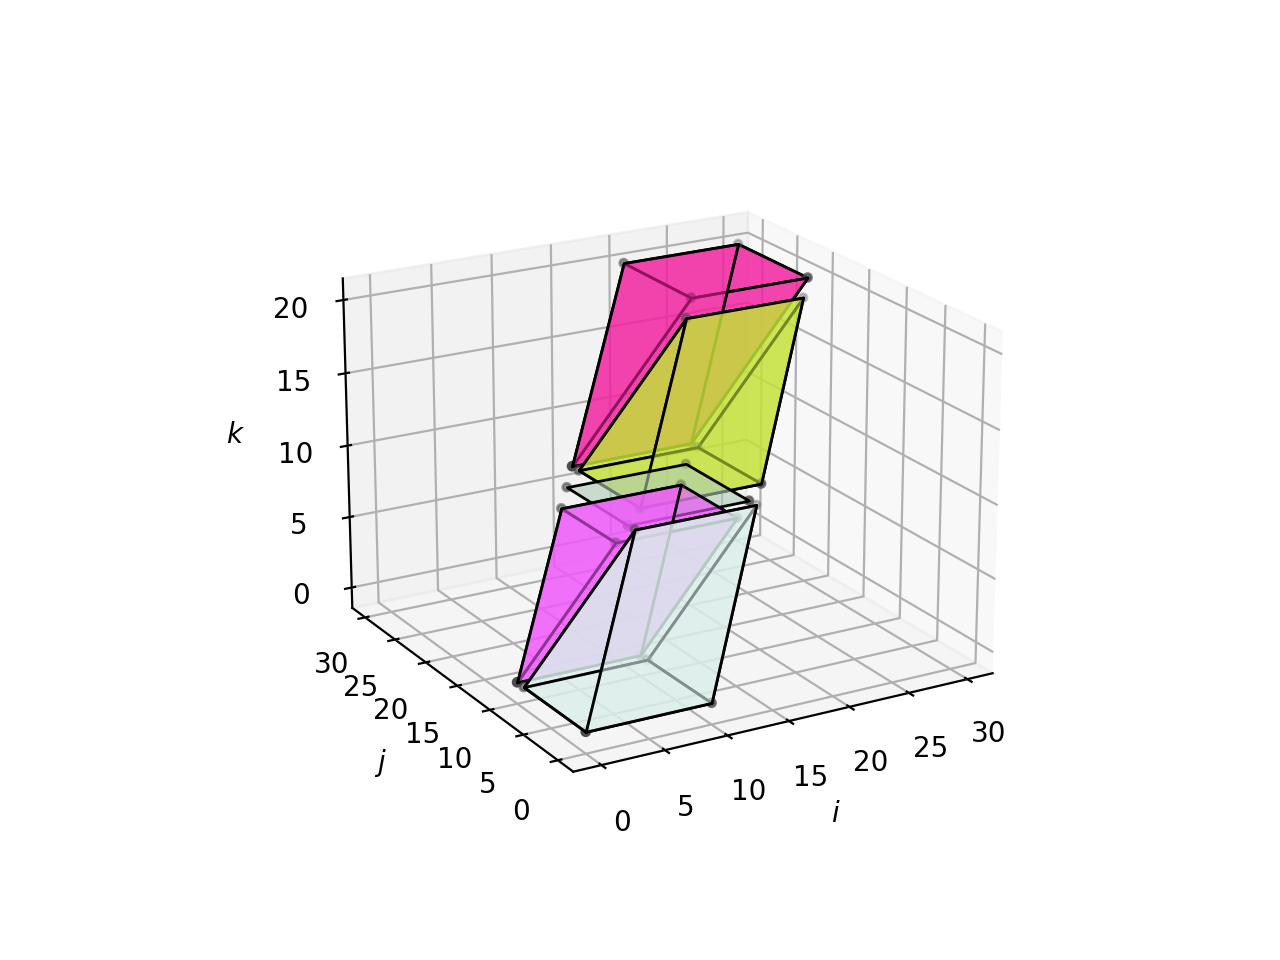

In [10]:
# 3D parallelpiped - v1
op = 'max'
fp = '[N,M]->{[i,j,k]->[j]}'
fd = '[N,M]->{[i,j,k]->[k]}'
s = '[N,M]->{[i,j,k] : k<=i,j<=N+k and 0<=k<=M and N<M}'
# visualization
dom = BasicSet('[N,M]->{[i,j,k] : N=10 and M=20}')

successes = start(op, fp, s, fd, verbose=False, report_all=False, check_homothety=False)

for success in successes:
    P = [p.intersect(dom) for p in success.get_splits(result=set())]
    plot_3d_sets(P)

This last one needs to be verified.
It's correct! Just need to specify the cell (i.e., the relationship between $M$ and $N$).